<a href="https://colab.research.google.com/github/Kirti-Pant/X-RVV-/blob/main/X_RVV_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Augmentation

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


augmented_train_dir = '/content/augmented_data'
os.makedirs(augmented_train_dir, exist_ok=True)


augmentations_per_image = 3

print(f"Augmenting {len(train_paths)} training images. Generating {augmentations_per_image} augmented images per original image.")

for i, img_path in enumerate(train_paths):
    try:
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)


        category = os.path.basename(os.path.dirname(img_path))


        category_folder = os.path.join(augmented_train_dir, category)
        os.makedirs(category_folder, exist_ok=True)


        prefix = f"{os.path.splitext(os.path.basename(img_path))[0]}_aug"


        gen_count = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=category_folder, save_prefix=prefix, save_format='jpeg'):
            gen_count += 1
            if gen_count >= augmentations_per_image:
                break

    except Exception as e:
        print(f"Error augmenting image {img_path}: {e}")

print("Augmentation process complete.")



# **X-RVV with Data Augmentation**

In [ ]:
import tensorflow as tf
from keras.applications import ResNet50, VGG19
from keras.layers import Input, Dense, Dropout, concatenate, GlobalAveragePooling2D, Resizing, Rescaling
from keras.models import Model
from keras.optimizers import Adam
from transformers import TFViTModel
import segmentation_models as sm


vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

IMG_SIZE = 224
NUM_CLASSES = 4


input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')


resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
resnet_out = GlobalAveragePooling2D()(resnet.output)


vgg = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
vgg_out = GlobalAveragePooling2D()(vgg.output)


vit_input = Resizing(224, 224)(input_tensor)
vit_input = Rescaling(1./255)(vit_input)

class TransposeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.transpose(inputs, perm=[0, 3, 1, 2])

vit_input_transposed = TransposeLayer()(vit_input)

class ViTBranch(tf.keras.layers.Layer):
    def call(self, inputs, training=False):
        outputs = vit_model({'pixel_values': inputs})
        return outputs.last_hidden_state[:, 0, :]

vit_out = ViTBranch()(vit_input_transposed)


merged = concatenate([resnet_out, vgg_out, vit_out])
x = Dense(1024, activation='relu')(merged)
x = Dropout(0.6)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
classification_output = Dense(NUM_CLASSES, activation='softmax', name='classification_output')(x)

segmentation_output = sm.Unet(
    backbone_name='resnet34',
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)(input_tensor)
segmentation_output._name = 'segmentation_output'

model = Model(inputs=input_tensor, outputs=[classification_output, segmentation_output], name="functional_37")


classification_model = Model(inputs=model.input, outputs=model.get_layer('classification_output').output, name="functional_37")


classification_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

classification_model.summary()


Segmentation Models: using `keras` framework.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 47,547,844 (181.38 MB)

 Trainable params: 47,494,724 (181.18 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        keras.callbacks.ModelCheckpoint('best_hybrid_model2.keras', save_best_only=True)
    ]
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.9797 - val_loss: 0.0723
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9982 - loss: 0.0084 - val_accuracy: 0.9833 - val_loss: 0.0746
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9971 - loss: 0.0072 - val_accuracy: 0.9760 - val_loss: 0.0924
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9976 - loss: 0.0085 - val_accuracy: 0.9797 - val_loss: 0.0730
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9957 - loss: 0.0142 - val_accuracy: 0.9775 - val_loss: 0.0823
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.9944 - loss: 0.0225 - val_accuracy: 0.9884 - val_loss: 0.0397
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9855 - val_loss: 0.0444
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9991 - loss: 0

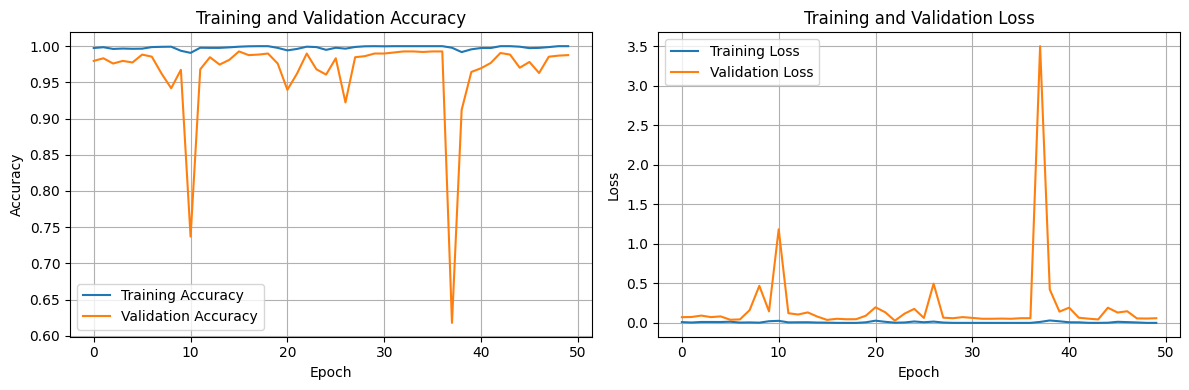

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
classification_model.save('best_hybrid_classification_model3.keras')